Fake news detection


Author: Ahmed Saied Ahmed Mohamed Elshita

mail: ahmedelshityfee53@gmail.com

Dataset: https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news

**Read datasets**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [14]:
newsData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection-main/fake_or_real_news.csv")

In [15]:
newsData.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [16]:
newsData.shape

(6335, 4)

**Data cleaning and preparation**

In [17]:
newsData.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [18]:
newsData.drop('Unnamed: 0' , axis=1,inplace=True)

In [19]:
newsData.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [20]:
newsData.isna().sum()

title    0
text     0
label    0
dtype: int64

In [21]:
newsData.dropna(inplace=True)

In [23]:
newsData.text = newsData.text.str.lower()

In [24]:
newsData.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"daniel greenfield, a shillman journalism fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",FAKE
4,The Battle of New York: Why This Primary Matters,it's primary day in new york and front-runners...,REAL


In [25]:
newsData.drop('title' , axis=1,inplace=True)

In [26]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

newsData.text = newsData.text.apply(punctuation_removal)

In [28]:
# Check
newsData.head()

,text,label
0,daniel greenfield a shillman journalism fellow...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,us secretary of state john f kerry said monday...,REAL
3,— kaydee king kaydeeking november 9 2016 the l...,FAKE
4,its primary day in new york and frontrunners h...,REAL


In [29]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

newsData['text'] = newsData['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Basic data exploration**

label
FAKE    3164
REAL    3171
Name: text, dtype: int64


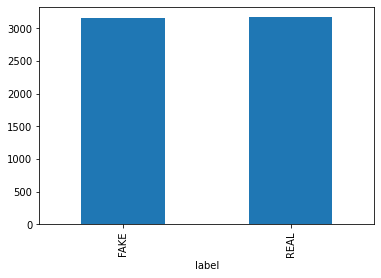

In [30]:
# How many articles per subject?
print(newsData.groupby(['label'])['text'].count())
newsData.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

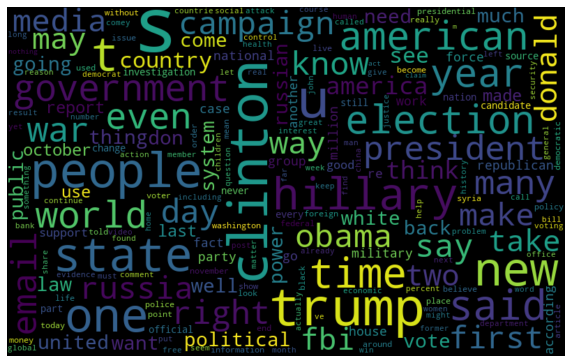

In [32]:
# !pip install wordcloud
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = newsData[newsData["label"] == "FAKE"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

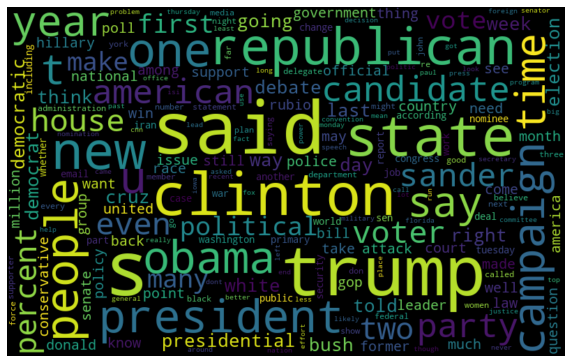

In [33]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = newsData[newsData["label"] == "REAL"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
# Most frequent words counter   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

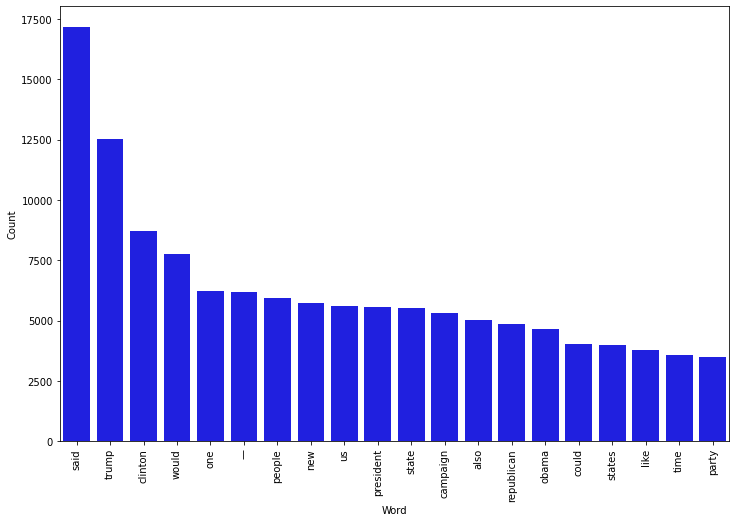

In [35]:
# Most frequent words in real news
counter(newsData[newsData["label"] == "REAL"], "text", 20)

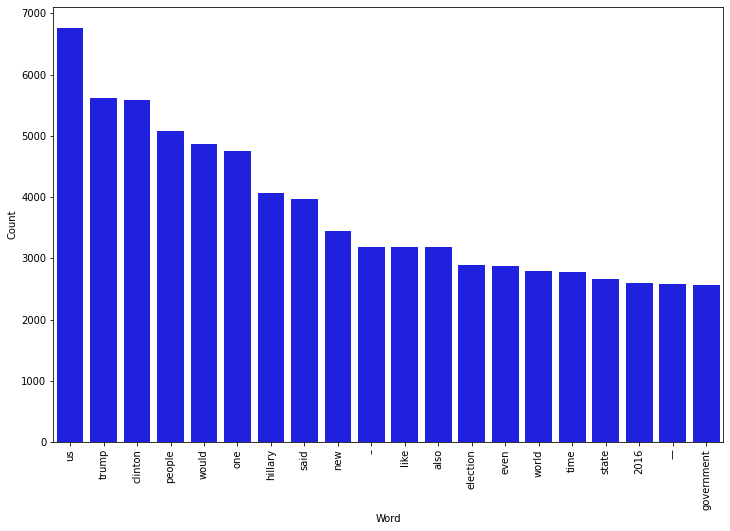

In [36]:
# Most frequent words in fake news
counter(newsData[newsData["label"] == "FAKE"], "text", 20)

**Modeling**

In [37]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Split Data**

In [38]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(newsData['text'], newsData.label, test_size=0.2, random_state=42)

**Decision Tree Classifier**

In [39]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 82.95%


Confusion matrix, without normalization


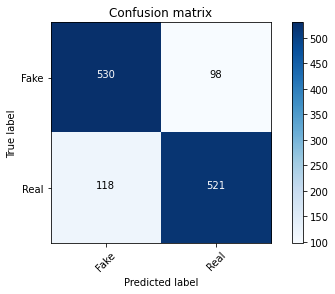

In [40]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])